In [19]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn import cluster

from kmodes.kprototypes import KPrototypes

In [41]:
df = pd.read_csv('/kaggle/input/obesity-dataset/ObesityDataSet_raw_and_data_sinthetic.csv')
df.shape

(2111, 17)

In [42]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [43]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


### Preprocessing

In [44]:
#Renaming columns for easier understanding and reference
df.rename(columns={'FAVC':'frequent_consumption_high_caloric_foods',
                        'FCVC':'frequent_consumption_veggies',
                        'NCP':'number_main_meals',
                        'CAEC':'snacks',
                        'CH2O':'consume_water',
                        'SCC':'monitor_calories',
                        'FAF':'frequency_physical_activity',
                        'TUE':'time_tech_devices',
                        'CALC':'consume_alcohol',
                        'MTRANS':'transporation_type',
                        'NObeyesdad':'obesity_level'},inplace=True)

In [45]:
df.select_dtypes(include=[object]).columns

Index(['Gender', 'family_history_with_overweight',
       'frequent_consumption_high_caloric_foods', 'snacks', 'SMOKE',
       'monitor_calories', 'consume_alcohol', 'transporation_type',
       'obesity_level'],
      dtype='object')

In [46]:
#Label & Ordinal Encoding

columns_to_auto_label_encode = ['Gender', 'family_history_with_overweight',
       'frequent_consumption_high_caloric_foods','SMOKE','monitor_calories','obesity_level']

X = [col for col in df.select_dtypes(include=[object]).columns if col in columns_to_auto_label_encode]

le = preprocessing.LabelEncoder()
df_clean = df.copy()
print("Mapping for Encoded Values:")
print("")

for col in X:
    le.fit(df[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

print("")
print("New dataframe with encoded features:")
for feature in X:
    df_clean[feature] = le.fit_transform(df[feature])
    
custom_order = ['no', 'Sometimes', 'Always', 'Frequently']
encoder = OrdinalEncoder(categories=[custom_order], dtype=int)
df_clean['snacks'] = encoder.fit_transform(df[['snacks']])
df_clean['consume_alcohol'] = encoder.fit_transform(df[['consume_alcohol']])
    
df_clean.head()

Mapping for Encoded Values:

{'Female': 0, 'Male': 1}
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
{'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}

New dataframe with encoded features:


,Gender,Age,Height,Weight,family_history_with_overweight,frequent_consumption_high_caloric_foods,frequent_consumption_veggies,number_main_meals,snacks,SMOKE,consume_water,monitor_calories,frequency_physical_activity,time_tech_devices,consume_alcohol,transporation_type,obesity_level
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,Public_Transportation,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,Public_Transportation,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,3,Public_Transportation,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,3,Walking,5
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,Public_Transportation,6


In [48]:
#OneHotEncoding
df_clean_2 = pd.get_dummies(df_clean,dtype='int')
df_clean_2.head()

,Gender,Age,Height,Weight,family_history_with_overweight,frequent_consumption_high_caloric_foods,frequent_consumption_veggies,number_main_meals,snacks,SMOKE,...,monitor_calories,frequency_physical_activity,time_tech_devices,consume_alcohol,obesity_level,transporation_type_Automobile,transporation_type_Bike,transporation_type_Motorbike,transporation_type_Public_Transportation,transporation_type_Walking
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,...,0,0.0,1.0,0,1,0,0,0,1,0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,...,1,3.0,0.0,1,1,0,0,0,1,0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,...,0,2.0,1.0,3,1,0,0,0,1,0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,...,0,2.0,0.0,3,5,0,0,0,0,1
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,...,0,0.0,0.0,1,6,0,0,0,1,0


In [49]:
df_continuous = df_clean_2.select_dtypes(exclude=[object])

correlation_matrix = df_clean_2.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

,Gender,Age,Height,Weight,family_history_with_overweight,frequent_consumption_high_caloric_foods,frequent_consumption_veggies,number_main_meals,snacks,SMOKE,consume_water,monitor_calories,frequency_physical_activity,time_tech_devices,consume_alcohol,obesity_level,transporation_type_Automobile,transporation_type_Bike,transporation_type_Motorbike,transporation_type_Public_Transportation,transporation_type_Walking
Gender,1.000000,0.048394,0.618466,0.161668,0.102512,0.064934,-0.274505,0.067600,-0.126272,0.044698,0.107930,-0.102633,0.189607,0.017269,0.002995,0.024908,0.137560,0.057001,0.045203,-0.160184,0.039317
Age,0.048394,1.000000,-0.025958,0.202560,0.205725,0.063902,0.016291,-0.043944,-0.108620,0.091987,-0.045304,-0.116283,-0.144938,-0.296931,0.061564,0.236170,0.604683,0.003652,0.020286,-0.554448,-0.063064
Height,0.618466,-0.025958,1.000000,0.463136,0.247684,0.178364,-0.038121,0.243672,-0.092776,0.055499,0.213376,-0.133753,0.294709,0.051912,0.121672,0.038986,0.077851,0.028996,-0.010471,-0.089684,0.036951
Weight,0.161668,0.202560,0.463136,1.000000,0.496820,0.272300,0.216125,0.107469,-0.357483,0.025746,0.200575,-0.201906,-0.051436,-0.071561,0.161257,0.387643,-0.013619,-0.021745,-0.037300,0.059332,-0.100805
family_history_with_overweight,0.102512,0.205725,0.247684,0.496820,1.000000,0.208036,0.040372,0.071370,-0.228038,0.017385,0.147437,-0.185422,-0.056673,0.022943,-0.037453,0.313667,0.099327,-0.015435,-0.051011,-0.058927,-0.067076
frequent_consumption_high_caloric_foods,0.064934,0.063902,0.178364,0.272300,0.208036,1.000000,-0.027283,-0.007000,-0.176748,-0.050660,0.009719,-0.190658,-0.107995,0.068417,0.058055,0.044582,0.057597,-0.082005,-0.035401,0.028539,-0.179473
frequent_consumption_veggies,-0.274505,0.016291,-0.038121,0.216125,0.040372,-0.027283,1.000000,0.042216,0.064960,0.014320,0.068461,0.071852,0.019939,-0.101135,0.045991,0.018522,-0.061049,-0.029843,-0.007512,0.057966,0.013991
number_main_meals,0.067600,-0.043944,0.243672,0.107469,0.071370,-0.007000,0.042216,1.000000,0.084502,0.007811,0.057088,-0.015624,0.129504,0.036326,0.056082,-0.092616,0.053424,0.023312,0.003875,-0.056849,0.006502
snacks,-0.126272,-0.108620,-0.092776,-0.357483,-0.228038,-0.176748,0.064960,0.084502,1.000000,0.048530,-0.167202,0.110914,0.031367,0.027920,-0.034575,-0.370566,-0.078815,-0.007472,0.082610,0.040873,0.057293
SMOKE,0.044698,0.091987,0.055499,0.025746,0.017385,-0.050660,0.014320,0.007811,0.048530,1.000000,-0.031995,0.047731,0.011216,0.017613,0.098847,-0.023256,0.011873,-0.008416,0.035496,-0.022409,0.017184


### KMeans

Text(0, 0.5, 'SSE')

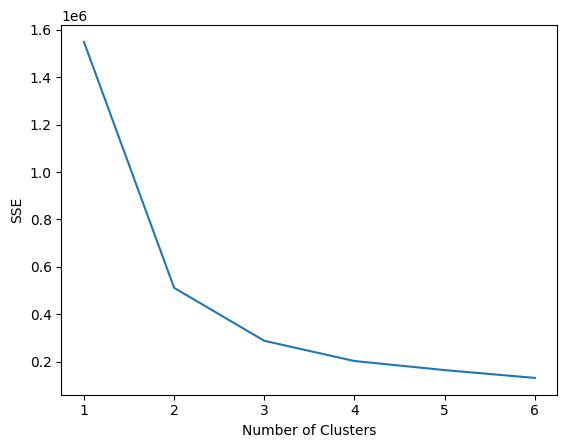

In [50]:
numClusters = [1,2,3,4,5,6]
SSE = []
data = df_clean_2
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k,n_init=10)
    k_means.fit(data)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [51]:
k_means = cluster.KMeans(n_clusters=3, max_iter=50, random_state=1)
k_means.fit(data) 
labels = k_means.labels_
pd.DataFrame(labels, columns=['Cluster ID'])

df_clean_2['Cluster ID'] = labels
df_clean_2.head()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Gender,Age,Height,Weight,family_history_with_overweight,frequent_consumption_high_caloric_foods,frequent_consumption_veggies,number_main_meals,snacks,SMOKE,...,frequency_physical_activity,time_tech_devices,consume_alcohol,obesity_level,transporation_type_Automobile,transporation_type_Bike,transporation_type_Motorbike,transporation_type_Public_Transportation,transporation_type_Walking,Cluster ID
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,...,0.0,1.0,0,1,0,0,0,1,0,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,...,3.0,0.0,1,1,0,0,0,1,0,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,...,2.0,1.0,3,1,0,0,0,1,0,2
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,...,2.0,0.0,3,5,0,0,0,0,1,2
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,...,0.0,0.0,1,6,0,0,0,1,0,2


Continuous features plotted against Weight


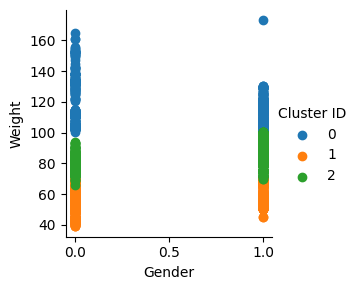

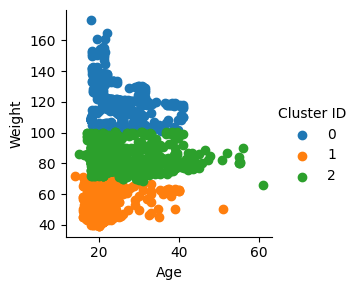

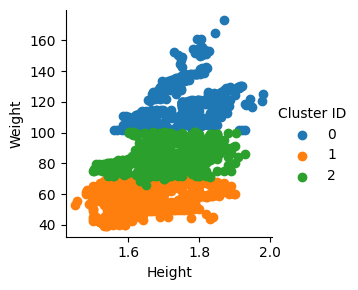

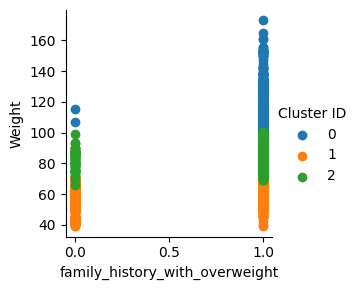

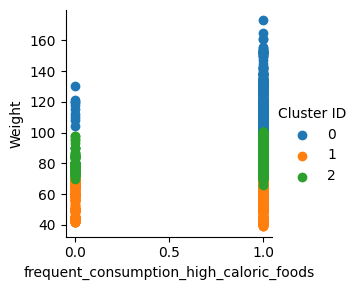

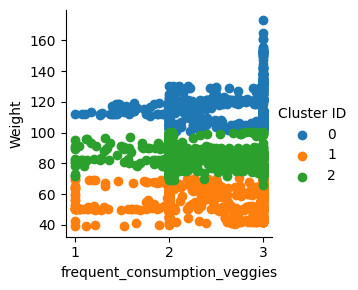

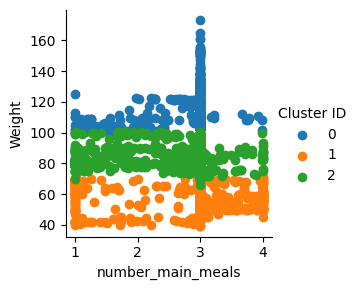

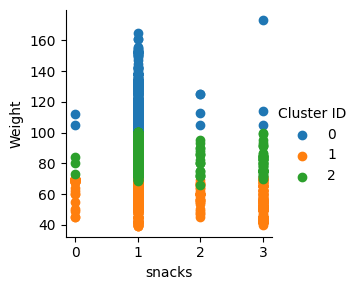

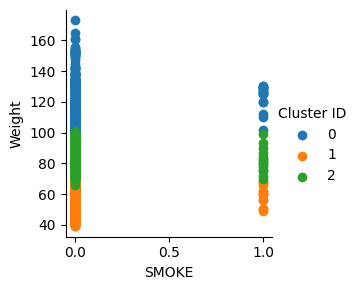

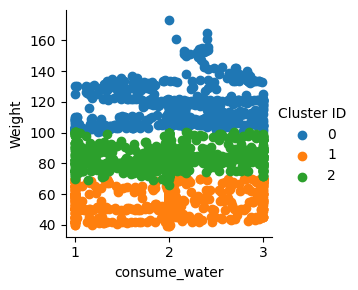

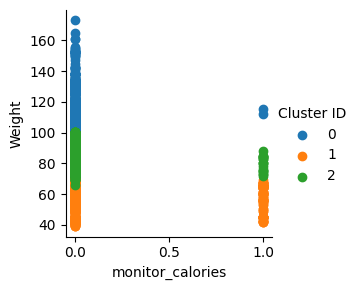

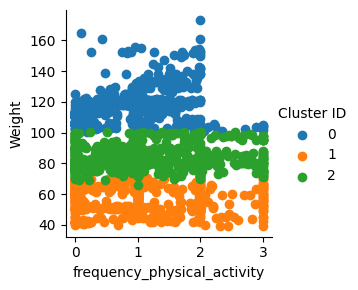

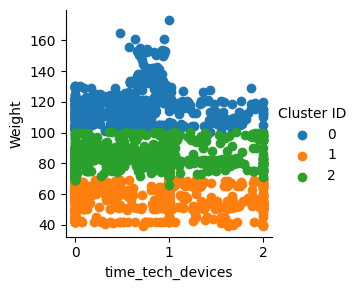

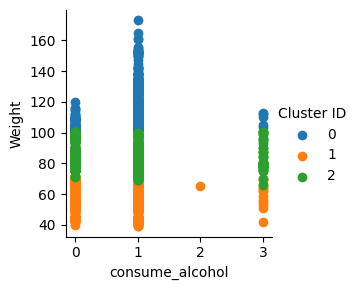

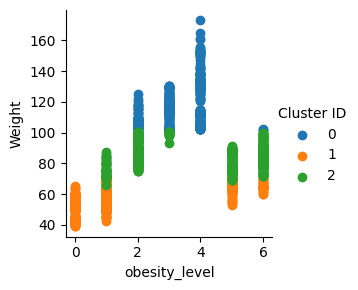

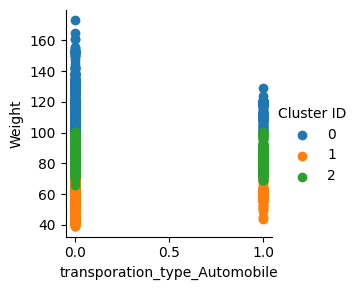

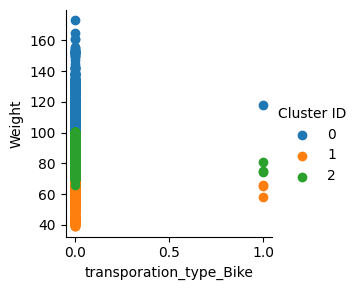

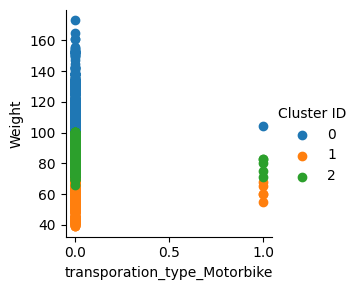

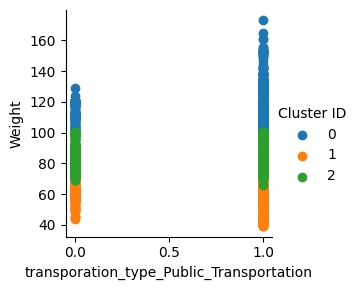

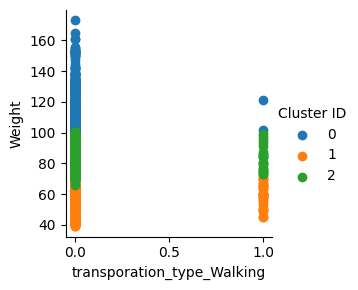

In [52]:
continuous_features = [x for x in df_clean_2.columns if x not in ['Weight','Cluster ID']]

print("Continuous features plotted against Weight")

for feature in continuous_features:
    fig = sns.FacetGrid(data=df_clean_2, hue='Cluster ID')
    fig.map(plt.scatter,feature, 'Weight').add_legend()

### Agglomerative Clustering

In [55]:
def draw_clusters(X, y=None, centerse=None, cluster_size=10000):
        _, ax = plt.subplots(figsize=(10,10))
        
        if y is not None:
            cm = {c: f"C{c}"for c in np.unique(y)}
            colors = [cm[i] for i in y]
        else:
            cm = None
            colors = "b"
        
        ax.scatter(X[:,0], X[:,1], color=colors)
        
        if centers is not None:
            colors = [cm[i] for i in range (len(centers))] if cm else "b"
            ax.scatter(
                centers[:,0], centers[:,1], marker="o",
                c=colors, alpha=0.25, s=clulster_size)
            
            ax.set_xlabel("$X_0$")
            ax.set_xticks([])
            ax.set_ylabel("$X_1$")
            ax.set_yticks([])

In [2]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering()
y = model.fit_predict(df_clean_2[['Weight']])
draw_clusters(df_clean_2[['Weight']], y)

NameError: name 'df_clean_2' is not defined